### CS 421 PROJECT

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew, kurtosis
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import random
import joblib

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [3]:
# Load the dataset
data = np.load("first_batch_multi_labels.npz")
X = data["X"]
y = data["yy"]

# Create DataFrames
df_X = pd.DataFrame(X, columns=["user", "item", "rating"])
df_y = pd.DataFrame(y, columns=["user", "label"])

def engineer_features(df_X, top_features=None, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby('user').agg(
        mean_rating=('rating', 'mean'),
        median_rating=('rating', 'median'),
        std_rating=('rating', 'std'),
        count_dislike=('rating', lambda x: (x == -10).sum()),
        count_neutral=('rating', lambda x: (x == 0).sum()),
        count_like=('rating', lambda x: (x == 10).sum()),
        count_watched=('rating', lambda x: (x == 1).sum()),
        total_interactions=('rating', 'count')
    )

    # Ratio features
    df_user_features['like_ratio'] = df_user_features['count_like'] / df_user_features['total_interactions']
    df_user_features['dislike_ratio'] = df_user_features['count_dislike'] / df_user_features['total_interactions']
    df_user_features['neutral_ratio'] = df_user_features['count_neutral'] / df_user_features['total_interactions']
    df_user_features['watched_ratio'] = df_user_features['count_watched'] / df_user_features['total_interactions']
    
    # Interaction patterns
    df_user_features['like_to_dislike_ratio'] = df_user_features['count_like'] / (df_user_features['count_dislike'] + 1)
    df_user_features['rating_variance'] = df_X.groupby('user')['rating'].var()
    
    # Distribution features
    df_user_features['rating_skew'] = df_X.groupby('user')['rating'].apply(lambda x: skew(x))
    df_user_features['rating_kurtosis'] = df_X.groupby('user')['rating'].apply(lambda x: kurtosis(x))
    
    # User behavior patterns
    df_user_features['rating_range'] = df_X.groupby('user')['rating'].apply(lambda x: x.max() - x.min())
    df_user_features['unique_items_ratio'] = df_X.groupby('user')['item'].nunique() / df_user_features['total_interactions']
    
    # Item popularity metrics
    item_popularity = df_X.groupby('item')['rating'].agg(['mean', 'count'])
    item_popularity['popularity_score'] = item_popularity['mean'] * np.log1p(item_popularity['count'])
    
    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(df_X, item_popularity['popularity_score'], left_on='item', right_index=True)
    
    # User-item interaction features
    df_user_features['mean_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].mean()
    df_user_features['std_item_popularity'] = df_X_with_popularity.groupby('user')['popularity_score'].std()

        
    # If labels are provided, merge with df_y
    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on='user')

        # Feature selection using mutual information
        X = df_merged.drop(columns=['user', 'label'])
        y = df_merged['label']
        mi_scores = mutual_info_classif(X, y)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        
        # Select top 15 features
        top_features = mi_scores.nlargest(15).index.tolist()

        # Return the merged dataframe with selected features, label, and top features
        return df_merged[['user'] + top_features + ['label']], top_features

    # If no labels (unseen data), just select the top features
    else:
        # Ensure top_features is provided
        if top_features is None:
            raise ValueError("top_features must be provided for unseen data")
        
        # Return the dataframe with only the selected top features
        df_merged = df_user_features.reset_index()
        return df_merged[['user'] + top_features]

# Use the function
df_merged, top_features = engineer_features(df_X, df_y=df_y)

# Features and Labels
X_features = df_merged.drop(columns=['user', 'label'])
y_labels = df_merged['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=RANDOM_SEED, stratify=y_labels)

# Handling imbalance using SMOTE
smote = SMOTE(random_state=RANDOM_SEED)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Model Training with Random Forest in One-vs-Rest scheme
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, class_weight='balanced')
ovr_model = OneVsRestClassifier(rf_model)

# Use a pipeline for scaling and modeling
pipeline = make_pipeline(StandardScaler(), ovr_model)
pipeline.fit(X_resampled, y_resampled)

# Predictions
y_pred_prob = pipeline.predict_proba(X_test)

# Evaluate with AUC for each class (Normal: class 0, Anomaly 1: class 1, Anomaly 2: class 2)
auc_scores = roc_auc_score(y_test, y_pred_prob, average=None, multi_class='ovr')

# Print the AUC scores for each class
print(f"AUC Scores: Normal (Class 0): {auc_scores[0]:.4f}, Anomaly 1 (Class 1): {auc_scores[1]:.4f}, Anomaly 2 (Class 2): {auc_scores[2]:.4f}")

AUC Scores: Normal (Class 0): 0.9840, Anomaly 1 (Class 1): 0.9876, Anomaly 2 (Class 2): 0.9967


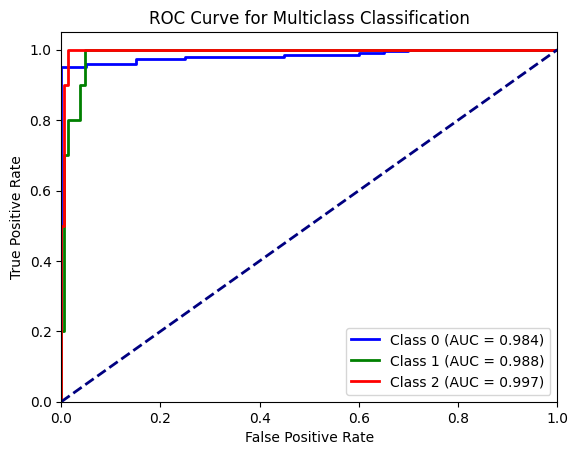

In [4]:
# Binarize the output labels for multiclass ROC curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

[[192   7   1]
 [  2   8   0]
 [  1   1   8]]


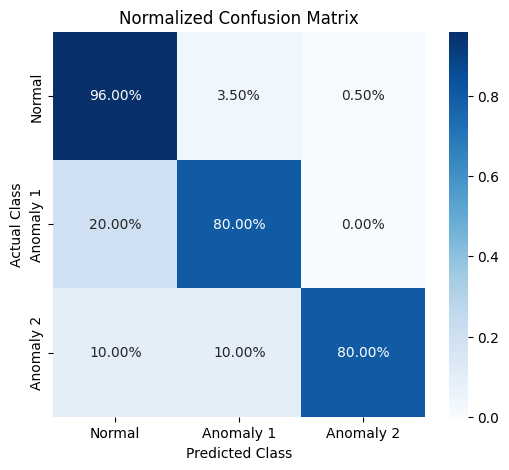

In [5]:
# Make predictions (convert probabilities to class labels)
y_pred = pipeline.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'], 
            yticklabels=['Normal', 'Anomaly 1', 'Anomaly 2'])

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [6]:
data_with_no_labels = np.load("second_batch_multi.npz")

df_X = pd.DataFrame(data_with_no_labels["X"], columns=["user", "item", "rating"])

df_unseen_features = engineer_features(df_X, top_features=top_features)

y_pred_prob_unseen = pipeline.predict_proba(df_unseen_features.drop(columns=['user']))

y_pred_class_unseen = pipeline.predict(df_unseen_features.drop(columns=['user']))

# Create a DataFrame to hold user IDs and their corresponding anomaly scores
df_anomaly_scores = pd.DataFrame({
    'user': df_unseen_features['user'],  # User IDs from unseen data
    'z0': y_pred_prob_unseen[:, 0],  # Probability for Normal class
    'z1': y_pred_prob_unseen[:, 1],  # Probability for Anomaly 1
    'z2': y_pred_prob_unseen[:, 2],   # Probability for Anomaly 2
    'predicted_class': y_pred_class_unseen   # Predicted class (0, 1, or 2)
})

df_anomaly_scores

,user,z0,z1,z2,predicted_class
0,1100,0.989899,0.010101,0.000000,0
1,1101,0.970297,0.009901,0.019802,0
2,1102,1.000000,0.000000,0.000000,0
3,1103,1.000000,0.000000,0.000000,0
4,1104,0.834862,0.064220,0.100917,0
...,...,...,...,...,...
1095,2195,0.960000,0.010000,0.030000,0
1096,2196,1.000000,0.000000,0.000000,0
1097,2197,1.000000,0.000000,0.000000,0
1098,2198,0.989796,0.010204,0.000000,0


In [7]:
df_anomaly_scores.to_csv("second_batch_anomaly_scores.csv", index=False)

In [16]:
pipeline[1].estimators_

[RandomForestClassifier(class_weight='balanced', random_state=42),
 RandomForestClassifier(class_weight='balanced', random_state=42),
 RandomForestClassifier(class_weight='balanced', random_state=42)]

In [30]:
# Get RF 1, see feature importances as its doing better than Alex's
def get_feature_importances(pipeline, clf_no: int):
    clf1 = pipeline[1].estimators_[clf_no]
    importances = clf1.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf1.estimators_], axis=0)
    forest_importances = pd.Series(importances,index = X_features.columns)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax = ax)
    ax.set_title(f"Feature importances for class {clf_no}: using Mean Decrease in Impurity")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

In [31]:
# std = np.std([tree.feature_importances_ for tree in clf1.estimators_], axis=0)

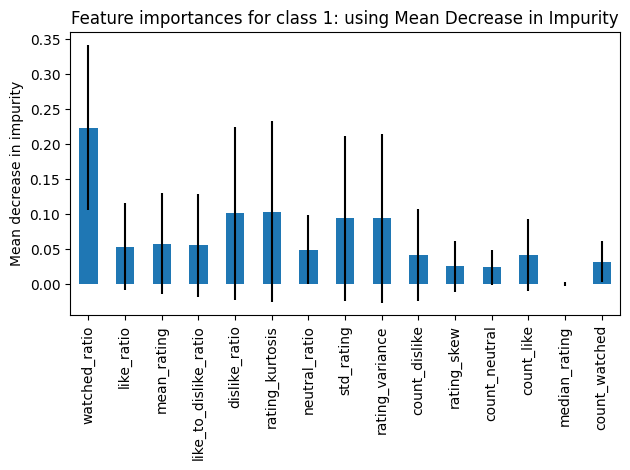

In [32]:
# forest_importances = pd.Series(importances,index = X_features.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax = ax)
# ax.set_title("Feature importances using Mean Decrease in Impurity")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()
# plt.show()
get_feature_importances(pipeline, clf_no = 1)

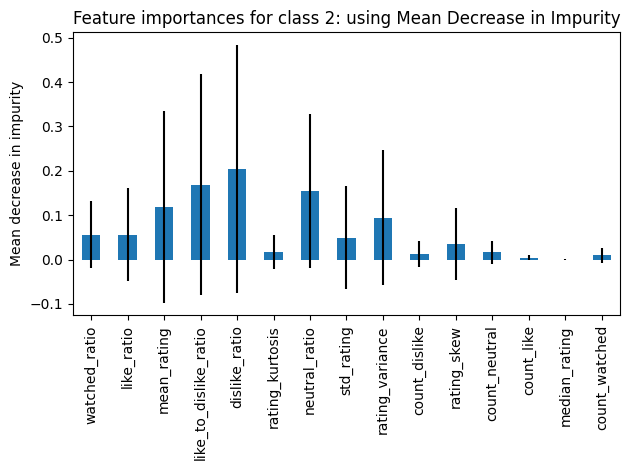

In [33]:
get_feature_importances(pipeline, clf_no = 2)

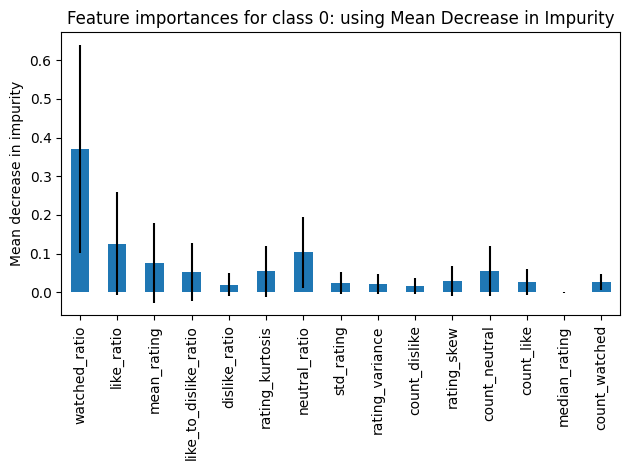

In [34]:
get_feature_importances(pipeline, clf_no = 0)

In [35]:
X_features

,watched_ratio,like_ratio,mean_rating,like_to_dislike_ratio,dislike_ratio,rating_kurtosis,neutral_ratio,std_rating,rating_variance,count_dislike,rating_skew,count_neutral,count_like,median_rating,count_watched
0,0.428571,0.240602,1.330827,1.523810,0.150376,-0.307358,0.180451,6.167758,38.041239,20,-0.269151,24,32,1.0,57
1,0.423913,0.206522,1.619565,2.111111,0.086957,0.535412,0.282609,5.238997,27.447086,8,-0.114285,26,19,1.0,39
2,0.391892,0.351351,1.743243,1.575758,0.216216,-1.037700,0.040541,7.380911,54.477845,32,-0.383767,6,52,1.0,58
3,0.400943,0.202830,0.731132,1.162162,0.169811,-0.280708,0.226415,6.107906,37.306514,36,-0.213976,48,43,1.0,85
4,0.490476,0.200000,1.966667,3.500000,0.052381,0.999560,0.257143,4.686725,21.965391,11,0.112749,54,42,1.0,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.507042,0.140845,0.647887,1.000000,0.126761,0.755367,0.225352,5.218370,27.231388,9,-0.272181,16,10,1.0,36
1096,0.431373,0.333333,2.980392,3.400000,0.078431,-0.147398,0.156863,5.777509,33.379608,4,-0.340488,8,17,1.0,22
1097,0.463190,0.113497,-1.070552,0.420455,0.266871,-0.555999,0.156442,6.121181,37.468853,87,-0.138924,51,37,1.0,151
1098,0.619048,0.126984,1.650794,4.000000,0.023810,3.283718,0.230159,3.616224,13.077079,3,0.750011,29,16,1.0,78
